In [1]:
#All necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC

In [2]:
df_model = pd.read_csv('fraud_model_data.csv',low_memory=False)
df_model

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,Birth_Year,Birth_Month,isDead,PotentialFraud,CostRange,ClaimPeriod_Bin,HospDuration_Bin,TotalClaimAmount,TotalReimbursement,TotalDeductible
0,BENE100000,CLM126832,2009-01-08,2009-01-08,PRV57172,50,PHY383401,0,0,0,...,1938,3,0,Yes,0-500,1–6,NaN,50.0,120,30
1,BENE100000,CLM351838,2009-05-10,2009-05-10,PRV57172,70,PHY370909,0,PHY363377,0,...,1938,3,0,Yes,0-500,1–6,NaN,70.0,120,30
2,BENE100001,CLM229075,2009-03-05,2009-03-05,PRV55158,70,PHY383478,0,0,0,...,1939,8,0,No,0-500,1–6,NaN,70.0,2530,540
3,BENE100001,CLM258631,2009-03-21,2009-03-21,PRV54966,70,PHY347511,0,0,0,...,1939,8,0,Yes,0-500,1–6,NaN,70.0,2530,540
4,BENE100001,CLM332544,2009-04-30,2009-05-02,PRV54890,90,PHY343317,PHY408367,PHY408367,0,...,1939,8,0,No,0-500,1–6,NaN,90.0,2530,540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE99999,CLM359214,2009-05-14,2009-05-14,PRV55826,80,PHY341548,0,0,0,...,1936,5,0,No,0-500,1–6,NaN,80.0,1270,690
558207,BENE99999,CLM475422,2009-07-17,2009-07-17,PRV54670,80,PHY351000,0,0,0,...,1936,5,0,No,0-500,1–6,NaN,80.0,1270,690
558208,BENE99999,CLM591853,2009-09-21,2009-09-21,PRV57336,30,PHY422310,PHY363262,0,0,...,1936,5,0,No,0-500,1–6,NaN,30.0,1270,690
558209,BENE99999,CLM712394,2009-12-03,2009-12-03,PRV51690,700,PHY379564,0,0,0,...,1936,5,0,No,501-1000,1–6,NaN,700.0,1270,690


In [3]:
df_model.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Claim_Period', 'Hospitalization_Duration',
       'ClaimStart_Year', 'ClaimStart_Month', 'ClaimEnd_Year',
       'ClaimEnd_Month', 'Inpatient_or_Outpatient', 'DOB', 'DOD', 'Gender',
       'Race', 'RenalDiseaseIndicator', 'State', 'County',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       '


Overall Accuracy: 0.7996

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84     69083
           1       0.73      0.76      0.74     42560

    accuracy                           0.80    111643
   macro avg       0.79      0.79      0.79    111643
weighted avg       0.80      0.80      0.80    111643



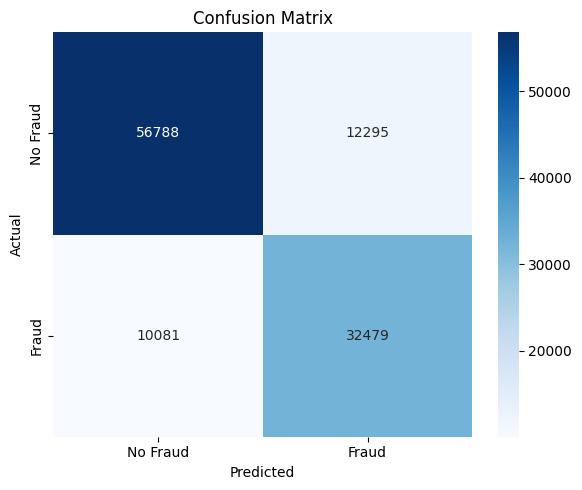

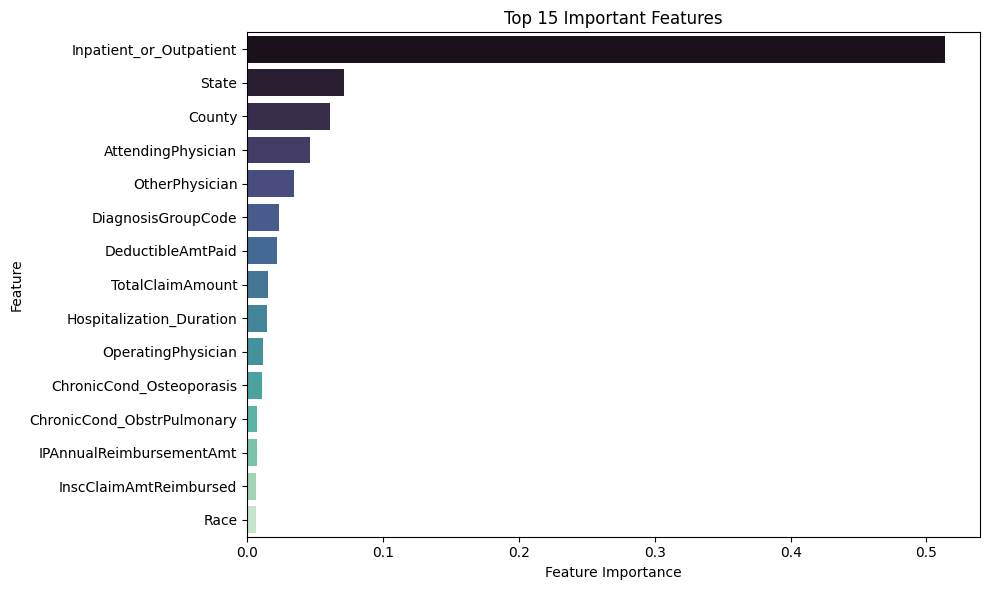

In [4]:
# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# -------------------- Feature Selection --------------------
exclude_cols = ['CostRange', 'ClaimPeriod_Bin', 'HospDuration_Bin', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov']
columns_to_model = df_model.columns.difference(exclude_cols + ['PotentialFraud'])

# Automatically identify columns
categorical_cols = ['Gender', 'Race', 'RenalDiseaseIndicator', 'Inpatient_or_Outpatient',
                    'State', 'County', 'DiagnosisGroupCode', 'ClmAdmitDiagnosisCode',
                    'ClaimStart_Month', 'ClaimEnd_Month']

diagnosis_cols = [f'ClmDiagnosisCode_{i}' for i in range(1, 11)]
procedure_cols = [f'ClmProcedureCode_{i}' for i in range(1, 7)]
physician_cols = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']
binary_health = [col for col in df_model.columns if 'ChronicCond' in col] + ['isDead']

numerical_cols = [
    'InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'Claim_Period', 'Hospitalization_Duration',
    'IPAnnualReimbursementAmt', 'OPAnnualReimbursementAmt',
    'IPAnnualDeductibleAmt', 'OPAnnualDeductibleAmt',
    'TotalClaimAmount', 'TotalReimbursement', 'TotalDeductible', 'Patient_Age'
]

selected_features = list(set(categorical_cols + diagnosis_cols + procedure_cols + physician_cols +
                             binary_health + numerical_cols) - set(exclude_cols))

# -------------------- Data Preprocessing --------------------
df = df_model[selected_features + ['PotentialFraud']].copy()
df['PotentialFraud'] = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Fill missing categorical with "Missing"
df[categorical_cols + diagnosis_cols + procedure_cols + physician_cols] = \
    df[categorical_cols + diagnosis_cols + procedure_cols + physician_cols].fillna("Missing")

# Encode categorical columns
le = LabelEncoder()
for col in (categorical_cols + diagnosis_cols + procedure_cols + physician_cols):
    df[col] = le.fit_transform(df[col])

# Impute numeric columns
imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# -------------------- Train/Test Split --------------------
X = df.drop('PotentialFraud', axis=1)
y = df['PotentialFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# -------------------- Train Model --------------------
model = XGBClassifier(random_state=42, scale_pos_weight=(y == 0).sum() / (y == 1).sum())
model.fit(X_train, y_train)

# -------------------- Evaluation --------------------
y_pred = model.predict(X_test)

# Print overall accuracy first
acc = accuracy_score(y_test, y_pred)
print(f"\nOverall Accuracy: {acc:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# -------------------- Confusion Matrix --------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# -------------------- Feature Importance --------------------
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.head(15), x='Importance', y='Feature', hue='Feature', dodge=False, legend=False, palette='mako')
plt.title('Top 15 Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


=== Decision Tree Evaluation ===
Accuracy       : 0.6963
Classification Report:
               precision    recall  f1-score   support

          No       0.68      0.95      0.80     69083
         Yes       0.79      0.28      0.41     42560

    accuracy                           0.70    111643
   macro avg       0.73      0.62      0.60    111643
weighted avg       0.72      0.70      0.65    111643

Confusion Matrix:
 [[65850  3233]
 [30675 11885]]

Top 10 Contributing Original Features (aggregated):
             OriginalFeature    Importance
0                   Provider  8.677675e-01
1         DiagnosisGroupCode  1.199729e-01
2                      State  4.976136e-03
3                     County  4.233092e-03
4         AttendingPhysician  3.050386e-03
5           ClmDiagnosisCode  1.949140e-14
6     ChronicCond_Depression  0.000000e+00
7      ChronicCond_Alzheimer  0.000000e+00
8         ChronicCond_Cancer  0.000000e+00
9  ChronicCond_KidneyDisease  0.000000e+00


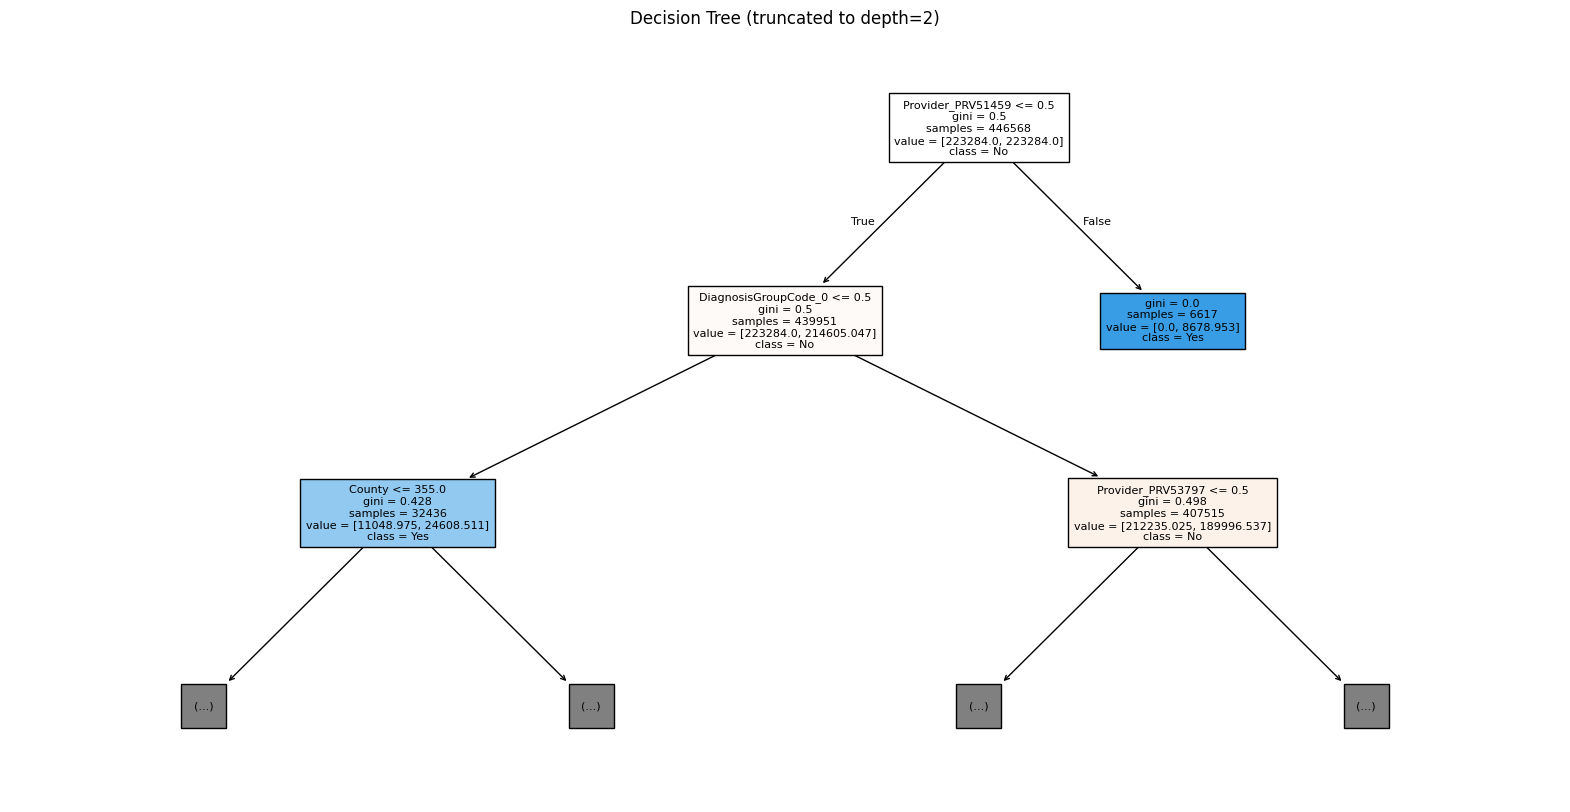

In [5]:
drop_cols = [
    'BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt',
    'DOB', 'DOD', 'CostRange', 'ClaimPeriod_Bin', 'HospDuration_Bin'
]

df = df_model.drop(columns=drop_cols)
target = 'PotentialFraud'
X = df.drop(columns=[target])
y = df[target]

# -------------------------------
# Step 2: Identify column types
# -------------------------------

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

# -------------------------------
# Step 3: Preprocessing pipelines
# -------------------------------

numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# -------------------------------
# Step 4: Train-test split
# -------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# -------------------------------
# Step 5: Decision Tree pipeline
# -------------------------------

dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=42))
])

# Train model
dt_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = dt_pipeline.predict(X_test)

# -------------------------------
# Step 6: Evaluation metrics
# -------------------------------

print("=== Decision Tree Evaluation ===")
print(f"Accuracy       : {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -------------------------------
# Step 7: Feature importance (aggregated to original features)
# -------------------------------

dt_clf = dt_pipeline.named_steps['classifier']
ohe = dt_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
all_feature_names = num_cols + list(cat_feature_names)

importances = dt_clf.feature_importances_

feature_df = pd.DataFrame({
    'EncodedFeature': all_feature_names,
    'Importance': importances
})

def get_original_feature(encoded_name):
    # For numeric columns (no underscore), just return the name
    if encoded_name in num_cols:
        return encoded_name
    # For onehot encoded features, format is like 'Provider_PRV51459', return prefix before '_'
    return encoded_name.split('_')[0]

feature_df['OriginalFeature'] = feature_df['EncodedFeature'].apply(get_original_feature)

top_features = feature_df.groupby('OriginalFeature')['Importance'].sum().sort_values(ascending=False).head(10)

print("\nTop 10 Contributing Original Features (aggregated):")
print(top_features.reset_index())

# -------------------------------
# Step 8: Optional - Plot Decision Tree (truncated)
# -------------------------------

plt.figure(figsize=(20, 10))
plot_tree(
    dt_clf, filled=True, max_depth=2,
    feature_names=all_feature_names,
    class_names=['No', 'Yes'],
    fontsize=8
)
plt.title("Decision Tree (truncated to depth=2)")
plt.show()


In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# You may need to install category_encoders
# !pip install category_encoders
from category_encoders import TargetEncoder

# Drop unwanted columns
drop_cols = ['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt',
             'DOB', 'DOD', 'CostRange', 'ClaimPeriod_Bin', 'HospDuration_Bin']
df = df_model.drop(columns=drop_cols)

# Define features and target
target = 'PotentialFraud'
X = df.drop(columns=[target])
y = df[target]

# Encode target if needed
y = y.map({'No': 0, 'Yes': 1})

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

# Preprocessing
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('targetenc', TargetEncoder())
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# SVM Pipeline
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42))
])

# Train
svm_pipeline.fit(X_train, y_train)

# Predict
y_pred = svm_pipeline.predict(X_test)

# Evaluation
print("\n=== SVM (RBF Kernel) Evaluation ===")
print(f"Accuracy       : {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['No', 'Yes']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



=== SVM (RBF Kernel) Evaluation ===
Accuracy       : 0.9980
Classification Report:
               precision    recall  f1-score   support

          No       1.00      1.00      1.00     69083
         Yes       1.00      1.00      1.00     42560

    accuracy                           1.00    111643
   macro avg       1.00      1.00      1.00    111643
weighted avg       1.00      1.00      1.00    111643

Confusion Matrix:
 [[68930   153]
 [   70 42490]]


In [8]:
df_model.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Claim_Period', 'Hospitalization_Duration',
       'ClaimStart_Year', 'ClaimStart_Month', 'ClaimEnd_Year',
       'ClaimEnd_Month', 'Inpatient_or_Outpatient', 'DOB', 'DOD', 'Gender',
       'Race', 'RenalDiseaseIndicator', 'State', 'County',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       '